In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Bifurcations de populations de neurones
======================

Le but de ce projet est de simuler l'évolution de l'activité moyenne de groupes de neurones en intéraction, à l'aide d'un modèle simplifié de *Wilson-Cowan*. En notant $x=(x_1,...,x_i,..., x_n)\in \mathbb{R}^n$ le vecteur contenant l'activité moyenne de chacun des $n$ groupes de neurones, ce modèle s'écrit (en grandeurs normalisées)
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
où $\tau$ est une constante de temps, $W \in \mathbb{R}^{n\times n}$ est une matrice décrivant les intéractions entre groupes de neurones, $d^{\rm ext}\in \mathbb{R}^n$ peut contenir des stimulis/perturbations extérieurs impactant chaque groupe, et $S: \mathbb{R}^n \to \mathbb{R}^n$ est de la forme
$$
S({\rm x}_1,...,{\rm x}_i ,...,{\rm x}_n) = (s_1({\rm x}_1),...,s_i({\rm x}_i),...,s_n({\rm x}_n))
$$
où $s_i:\mathbb{R}\to \mathbb{R}$ sont des fonctions dîtes d'*activation*.

Ces fonctions d'activation permettent de modéliser le fait que l'activité environnante d'un groupe de neurone doit atteindre un certain seuil avant d'exciter ce groupe. Des choix courants de fonctions d'activation sont la tangente hyperbolique ou des sigmoides de la forme
$$
s({\rm x}) = \frac{1}{1+ e^{-a(x-\theta)}}-\frac{1}{1+e^{a\theta}}
$$
où $\theta$ représente le seuil d'activation et $a$ sa pente, comme illustré ci-dessous. 

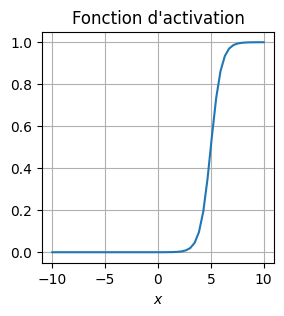

In [2]:
def sigmoid(x):
    a = 2.0   # la pente au niveau du seuil est a/4
    theta = 5.0  # seuil
    return 1/(1+np.exp(-a*(x-theta)))-1/(1+np.exp(a*theta))

x = np.linspace(-10,10)
plt.figure()
plt.plot(x,sigmoid(x))
plt.grid(True)
plt.xlabel('$x$')
plt.title("Fonction d'activation")
plt.show()

Notons que si l'on réécrit l'équation différentielle composante par composante, on trouve que la dynamique de chaque groupe de neurone s'écrit
$$
\tau \dot x_i = -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)
$$

**Question 1** Justifier que si les fonctions d'activation $s_i:\mathbb{R}\to \mathbb{R}$ sont bornées (minorées et majorées) alors toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$ et sont bornées. Relier la borne de $t\mapsto x_i(t)$ à la borne de $s_i$ pour chaque $i$. 

On pose pour tout i compris entre 1 et N, la fonction f : $x\mapsto -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)$ qui est continue. 
On note $S_i$ la borne de $s_i$. 
Pour t appartenant à $\mathbb{R}$, $|f_i({\rm x})|\le|x_i|+S_i$. 
D'après le critère d'existence globale, on a que toutes les solutions maximales $x_i$ sont définies sur $\mathbb{R}$. 

Montrons que $|x_i|<S_i$. 
Si $x_i=S_i$, 
alors $\tau \dot x_i=-x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)\le0$. 
Donc x décroit et ne dépasse pas $S_i$.
De même pour le cas négatif. 
On a ainsi que $x_i$ est bornée et que sa borne est égale $S_i$. 

CONTRE-EXEMPLE:
si $s(t)=1$  et $x_{i}(0)=12 $ alors on a $ \tau \dot x_i=-x_i + 5$ d'où $$ x_{i}(t)=7e^{-t/\tau} +5 $$
Alors, $  x_{i}(t) /leq S $ n'est pas toujours vraie.

On peut aussi travailler avec l'expression d'une solution de l'équation différentielle et raisonner à partir de cela.

Les solutions homogènes sont de la forme:
$$ x_{ih}(t)=A_{i} e^{-t/\tau},  A_{i} \in \mathbb{R} $$

En utilisant une méthode de variation de la constante, on peut trouver des solutions particulières de la forme:
$$ x_{ip}(t)= \ \int_{0}^{t} \frac{ {s({W}\cdot{x(u)} +d_{ext}) e^{+u/\tau} }} { {\tau}} \ du \  e^{-t/\tau}  $$

Ainsi, une solution peut, de façon générale, s'écrire sous la forme:
$$ x_{i}(t)= (  \ \int_{0}^{t} \frac{ {s({W}\cdot{x(u)} +d_{ext}) e^{+u/\tau} }} { {\tau}} \ du \ + A_{i})e^{-t/\tau} , A_{i} \in \mathbb{R}  $$

En notant $ S_{-} $ et $ S_{+} $ les bornes de $s$, on en déduit par croissance de l'intégrale que: 
$$     e^{-t/\tau} ( x_{0} + S_{-}( e^{+t/\tau} -1 )) \leq x(t) \leq   e^{-t/\tau} ( x_{0} + S_{+}( e^{+t/\tau} - 1)) $$

On en déduit ainsi que: $$   e^{-t/\tau} x_{0} + S_{-}( 1 - e^{-t/\tau} ) \leq x(t) \leq   e^{-t/\tau} x_{0} + S_{+}( 1 -  e^{-t/\tau} ) $$

Finalement,  si on ajoute la condition   $$ S_{-} \leq x_{0}  \leq S_{+} $$ , alors pour tout $ t >0 $, $$ | x_{i}(t) | \leq min(|  S_{-} | , | S_{+} | ) $$

Pour simplifier, on étudie ce système en dimension 2, c'est-à-dire avec deux groupes de neurones: le premier ayant un effet *excitant* et le deuxième *inhibant*. On traduit cela par la matrice d'interconnection suivante.

In [3]:
W = np.array([[5.0, -4.0], [8.0, -1.0]])
print(W)

[[ 5. -4.]
 [ 8. -1.]]


On fixe aussi $s_1=s_2$ données par la sigmoide ci-dessus, ainsi que $\tau=1$ puisque faire varier $\tau$ ne change que l'échelle de temps. On va essayer d'étudier et exploiter la grande richesse de comportements asymptotiques possibles pour différentes valeurs de $d^{\rm ext}$.

Points d'équilibre
================

On commence par considérer $d^{\rm ext}$ constant. Ses composantes $d_1^{\rm ext}$ et $d_2^{\rm ext}$ peuvent donc être vus comme des paramètres du système. Les points d'équilibre $x^{\rm eq}\in \mathbb{R}^n$ se caractérisent alors par l'équation
$$
x^{\rm eq} = S(W x^{\rm eq} + d^{\rm ext})
$$
La fonction suivante trace les points $(x_1,x_2)$ tels que $-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ (en rouge) et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$ (en vert) pour des valeurs de $d^{\rm ext}$ à choisir.

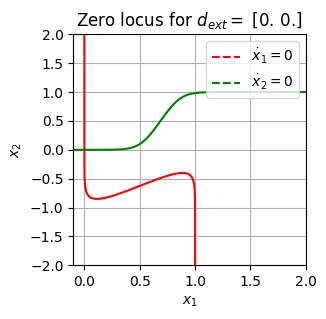

In [4]:
def plot_zero_locus(d_ext):
    grid_x1 = np.linspace(-0.1,2.0,100)
    grid_x2 = np.linspace(-2.0,2.0,100)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    plt.figure()
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return


d_ext = np.array([0.0,0.0])  # A CHOISIR
plot_zero_locus(d_ext)

**Question 2** Identifier le point d'équilibre du système pour $d^{\rm ext}=0$ et étudier sa stabilité. 


**Question 3** Tester d'autres valeurs de $d^{\rm ext}$. Par exemple, fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 8. Qu'observe-t-on sur le nombre de points d'équilibre ? Pour $d^{\rm ext}=(6,4)$, on trace ci-dessous le portrait de phase. Retrouver graphiquement les points d'équilibre et intuiter leur stabilité. Quels sont les seuls comportements asymptotiques possibles des solutions pour cette valeur constante de $d^{\rm ext}$ ?

In [5]:
def fonction(x): #définition de la fonction f régissant le système différentiel 
    res=np.zeros((2,1))
    res[0]=-x[0]+sigmoid(W[0,0]*x[0] + W[0,1]*x[1] + d_ext[0])
    res[1]=-x[1] + sigmoid(W[1,0]*x[0] + W[1,1]*x[1] + d_ext[1])
    return res

def jacobienne(fonction, x): #calcule de la jacobienne d'une fonction en un point x
    n = len(x)
    m = len(fonction(x))
    J = np.zeros((m, n))
    h = 1e-8

    for i in range(n):
        x=np.array(x)
        newx = x.copy()
        newx[i]= newx[i]+h
        J[:, i] = np.reshape((fonction(newx) - fonction(x)) / h,(2,))
    return J

#affichage des valeurs propres de la jacobienne de f en (0,0)
J=jacobienne(fonction,(0.0,0.0))
vap = np.linalg.eigvals(J) 
print(vap)

[-0.99981842+0.00043542j -0.99981842-0.00043542j]


2) Le point d'équilibre correspond à $\dot x_i=0$ soit d'après le point d'intersection des deux courbes du graphique à (0,0). D'après le programme précédent, les valeurs propres de la jacobienne de la fonction f en (0,0) sont toutes à partie réelle strictement négative donc le point d'équilibre (0,0) est localement asymptotiquement stable. De plus, on constate graphiquement que les deux courbes du graphique ne semblent pas avoir d'autres points d'intersection donc que (0,0) est le seul point d'équilibre du système, donc qu'il est globalement asymptotiquement stable. Il est donc, a fortiori, stable. 

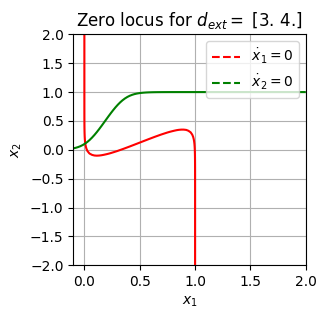

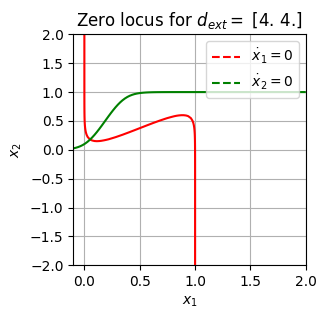

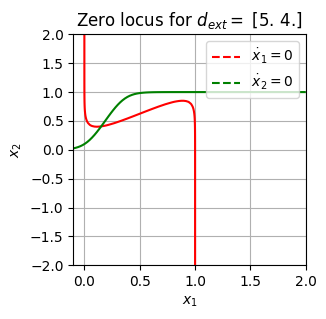

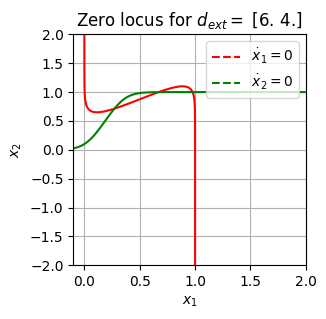

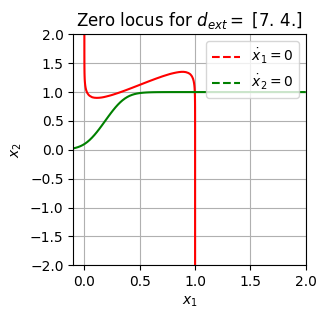

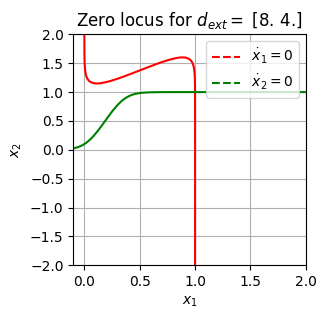

In [6]:
d_ext = np.array([3.0,4.0])  
plot_zero_locus(d_ext)

d_ext = np.array([4.0,4.0])  
plot_zero_locus(d_ext)

d_ext = np.array([5.0,4.0])  
plot_zero_locus(d_ext)

d_ext = np.array([6.0,4.0])  
plot_zero_locus(d_ext)

d_ext = np.array([7.0,4.0])  
plot_zero_locus(d_ext)

d_ext = np.array([8.0,4.0])  
plot_zero_locus(d_ext)

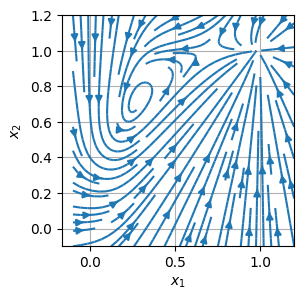

In [6]:
d_ext = np.array([6.0,4.0])  

grid_x1 = np.linspace(-0.1,1.2,70)
grid_x2 = np.linspace(-0.1,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

3) Le nombre de points d'équilibre du système n'est pas constant. Pour $d^{\rm ext}_2=4$, on constate que selon la valeur de $d^{\rm ext}_1$ variant entre 3 et 8, il y a un, deux ou trois points d'équilibre avec notamment trois points d'équilibre autour de $d^{\rm ext}_1=6$. 

On retrouve ensuite sur le portrait de phase que les trois points d'équilibre correspondant à cette valeur sont environ égaux à $x^{\rm eq1}$=(0.3,0.7), $x^{\rm eq2}$=(0.7,1.0), $x^{\rm eq3}$=(1.0,1.0).
D'après le portrait de phase, $x^{\rm eq1}$ et $x^{\rm eq3}$ sont stables car les solutions initialisées autour de ces points convergent vers ces derniers. Ce n'est pas le cas de $x^{\rm eq2}$ où les solutions avoisinnantes s'éloignent du point d'équilibre. 

Ainsi, les comportements asymptotiquements possibles pour cette valeur de $d^{\rm ext}$ sont la convergence vers $x^{\rm eq1}$ ou $x^{\rm eq3}$ selon leurs valeurs initiales des solutions plus ou moins proches de ces deux points, ou une convergence vers $x^{\rm eq2}$ si la solution initiale est pile égale à $x^{\rm eq2}$, du fait de l'instabilité de ce point d'équilibre.  

Lorsque le nombre et la nature (stabilité) des points d'équilibre changent brusquement avec des modifications de paramètres, on parle de *bifurcation*. De tels phénomènes permettent généralement de produire des comportements asymptotiques extrêmement riches et variés, simplement en faisant varier ces paramètres. Nous en étudions plusieurs exemples dans la suite.

Simulation des trajectoires
================

**Question 4** Compléter la fonction ``solve_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant e vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$.

In [7]:
# Question 4
def solve_euler_explicit(f, x0, dt, t0, tf):
    n=int((tf-t0)/dt)
    t=np.linspace(t0,tf,n)
    x=np.zeros((n,len(x0)))
    x[0]=x0
    for i in range(1,n):       
        x[i]=x[i-1]+f(t[i-1],x[i-1])*dt 
    return t,x

**Question 5** Expliquer (sans le faire) comment on pourrait trouver numériquement l'ordre de convergence de ce schéma.

5) Il faudrait définir un temps tf sur lequel exécuter le schéma Euler explicite. Il faudrait ensuite définir une fonction qui calcule à tout temps $t_j$ de l'échantillonage, $$\lVert x^{\rm j}-x({\rm t_j}) \rVert$$ et en prend le maximum. 
Enfin, il faudrait en partant d'une valeur p=0, évaluer la valeur renvoyée par cette fonction divisée par $(dt)^{\rm p}$ pour plusieurs valeurs de dt de plus en plus petites. Si on constate que cette quantité tend vers 0 en faisant tendre la valeur de dt vers 0, alors on augmente p de 1 et on recommence, jusqu'à que la quantité ne tende plus vers 0 quand dt tend vers 0. Si pour ce dernier p, cette quantité est bornée quand dt tend vers 0, alors on a p est l'ordre de convergence du schéma. Si ça n'est pas le cas, alors p-1 est l'ordre de convergence du schéma. 



**Question 6** On utilise maintenant ``solve_euler_explicit`` pour simuler des trajectoires de neurones lorsque $d^{\rm ext}$ est constant. En vous aidant du portrait de phase de la question 3, illustrer les comportements asymptotiques possibles des solutions pour $d^{\rm ext}=(6,4)$, en choisissant différentes conditions initiales. Lequel ne peut-on pas illustrer numériquement ?

[[0.7        0.2       ]
 [0.72993437 0.27998039]
 [0.75685055 0.35196686]
 ...
 [0.97755292 0.9999458 ]
 [0.97755292 0.9999458 ]
 [0.97755292 0.9999458 ]]


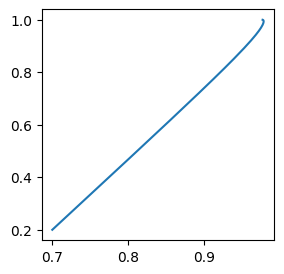

In [15]:
def f_d_ext_constant(t,x):
    d_ext = np.array([6.0,4.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)

#Cas où le système converge vers le point d'équilibre 1 
x0 = np.array([0.2,0.8])
dt = 0.1
t0, tf = 0.0, 100.0
time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
print(x)
plt.plot(x[:,0],x[:,1])
plt.show()

#Cas où le système converge vers le point d'équilibre 3
x0 = np.array([0.7,0.2])
dt = 0.1
t0, tf = 0.0, 1000.0
time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
#print(x)
#plt.plot(x[:,0],x[:,1])
#plt.show()

6) En utilisant le portrait de phase précédent, on choisit des conditions initiales permettant respectivement la convergence vers $x^{\rm eq1}$ et $x^{\rm eq3}$ en se plaçant au niveau de flèches orientées vers ces points sur le portrait de phase. On constate alors que les valeurs renvoyées par l'algorithme sont proches de celles estimées en question 3) ((0.3,0.7) et (1.0,1.0) environ). Le comportement de la solution constante égale à $x^{\rm eq2}$ ne peut être illustrée numériquement car il impliquerait de connaitre avec une précision parfaite la valeur de $x^{\rm eq2}$ (pour la définir en condition initiale) ce qui est impossible dans notre étude. 

**Question 7** On fixe maintenant $d_2^{\rm ext}=8$ et on fait varier $d_1^{\rm ext}$ lentement de 4 à 8, puis de 8 à 4. En utilisant ``plot_zero_locus``, justifier le comportement de la solution obtenue. Tracer la solution en fonction de $d_1^{\rm ext}$, comment appelle-t-on ce phénomène ? Justifier que l'on parle de *mémoire courte*.

In [31]:
def d_ext_varying(t):
    d1_ext = (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)
    d2_ext = 8.0*np.ones(np.shape(t))
    return np.array([d1_ext,d2_ext])

def f_d_ext_varying(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_varying(t))

x0 = np.array([0.0,1.0])
dt = 0.1
t0, tf = 0.0, 80.0


[2.20959326e-05 9.82589093e-01]


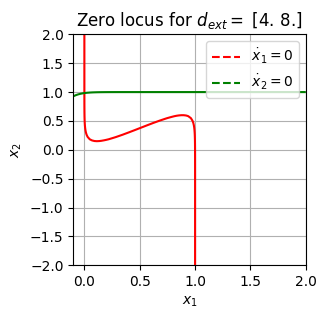

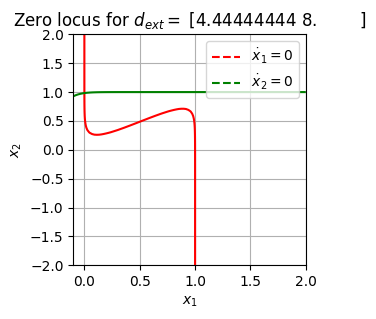

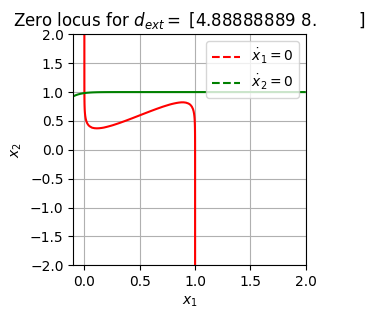

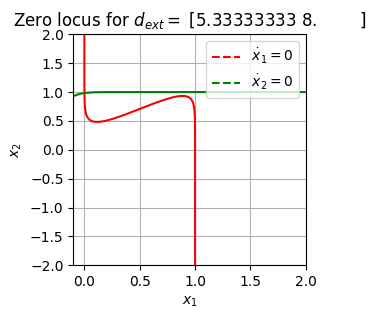

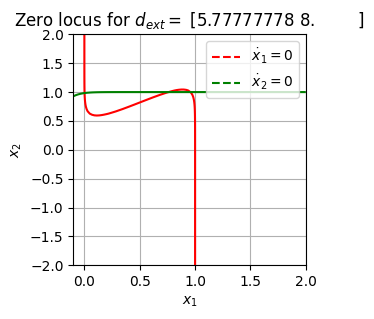

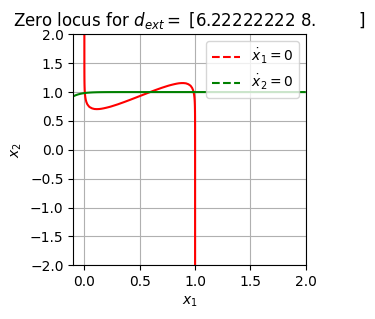

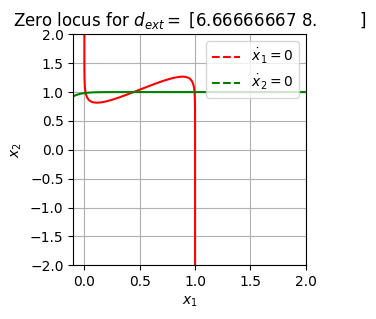

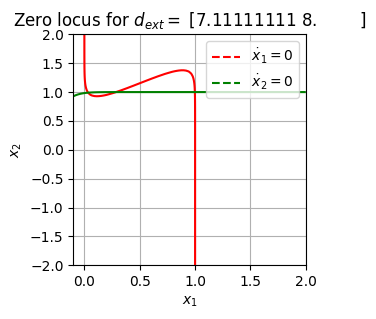

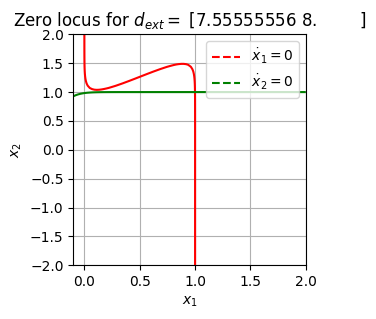

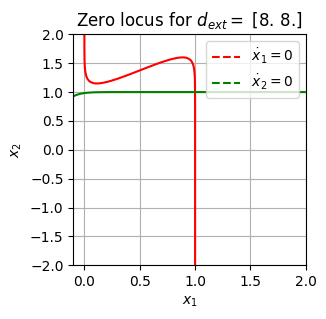

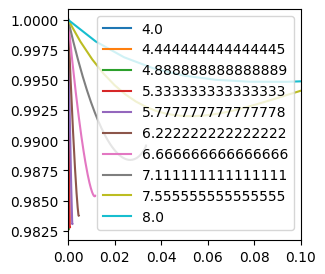

In [34]:
def d_ext_1_var(d1):
    return np.array([d1,8.0])

def f_d_1_varying(d1,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_1_var(d1))

x0 = np.array([0.0,1.0])
dt = 0.1
t0 , tf = 0.0 , 80.0
N=10

t,x=solve_euler_explicit(f_d_ext_varying, x0, dt, t0, tf)
print(x[-1])

for d1 in list(np.linspace(4.0,8.0,N)):
    plot_zero_locus(np.array([d1,8.0]))


i=0  
plt.figure()
for d1 in list(np.linspace(4.0,8.0,N)):
    i+=1
    def g(t,x):
        return f_d_1_varying(d1,x)        
    plt.plot(solve_euler_explicit(g, x0, dt, t0, tf)[1][:,0],solve_euler_explicit(g, x0, dt, t0, tf)[1][:,1],label=d1)

plt.legend()   
plt.xlim(0,0.1)
plt.show()

 

7) On constate que la solution converge vers environ (0.0,1.0), à savoir le point d'équilibre correspondant aux d_ext autour de (4.0,8.0) d'après les tracés de plot_zero_locus et les points d'intersection des deux courbes. Cela s'explique par le fait que d_ext tend aux temps longs vers (4.0,8.0) et donc que la solution converge vers le point d'équilibre du système pour cette distance qui est la dernière prise en paramètre auc ours de l'exécution. 
On est ici confronté à un phénomène de chaos: en modifiant légèrement les paramètres du système, la solution adopte un comportement complètement différent de son comportement initial, qui le rend donc imprévisible (d'après le dernier graphique où la solution converge vers des points d'équilibre différents).
On parle ici de mémoire courte car malgré la modification de d_ext censée perturber le système et modifier sa convergence, comme d_ext retourne à la valeur finale de (4.0,8.0), le système finit par converger vers le point d'équilibre associée à cette distance, ne prenant en compte que cette valeur finale, comme s'il ne s'était passé aucune modification de d_ext, d'où le terme de "mémoire courte". 

Bendixon et cycle limite
============================

On cherche maintenant à faire apparaître un cycle limite oscillatoire. On s'appuie pour cela sur le théorème de *Bendixon* qui décrit le comportement possible de solutions bornées d'équations différentielles en dimension 2:

    ''Pour une équation différentielle de dimension 2 définie par une fonction continument différentiable, toute solution maximale bornée converge soit vers un point soit vers une fonction périodique du temps appelée *cycle limite*''
    
**Question 8** Justifier que l'on recherche alors une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable. 

**Question 9** La fonction ci-dessous permet de tracer les zéros de la dynamique comme ci-dessus mais superposés aux zones où la trace de la jacobienne de $f$ est strictement négative et son déterminant strictement positif. Compléter le calcul de la jacobienne et proposer une méthode empirique pour trouver une valeur de $d_{\rm ext}$ donnant un cycle limite. Vérifier en simulation l'apparition de ce cycle limite.

8) Comme nous sommes en dimension 2 et que les solutions de l'équation sont bornées d'après la question 1, on peut appliquer le théorème de Bendixon. 
En effet, en se plaçant dans le cas où l'on dispose d'un unique point d'équilibre qui est instable, il est impossible pour une solution maximale de converger vers un point (car elle convergerait vers le point d'équilibre ce qui est impossible du fait de son instabilité ). 

D'après ce théorème, la solution converge bien vers un cycle limite. 

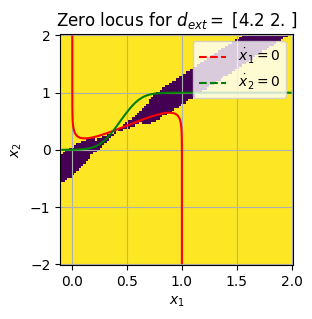

In [24]:
# question 9
def jacobian_dynamics(x1,x2,d_ext):
    dt=1e-9
    mat_Jac=np.zeros((2,2))
    def f(x1,x2):
        x=np.array([x1,x2])
        return -x + sigmoid(np.dot(W,x)+d_ext)
    mat_Jac[0][0]=(f(x1+dt,x2)[0]-f(x1,x2)[0])/dt
    mat_Jac[0][1]=(f(x1,x2+dt)[0]-f(x1,x2)[0])/dt
    mat_Jac[1][0]=(f(x1+dt,x2)[1]-f(x1,x2)[1])/dt
    mat_Jac[1][1]=(f(x1,x2+dt)[1]-f(x1,x2)[1])/dt
    return mat_Jac

def plot_zero_locus_stabilite(d_ext):
    N = 100
    grid_x1 = np.linspace(-0.1,2.0,N)
    grid_x2 = np.linspace(-2.0,2.0,N)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)


    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    # compute trace and determinant of jacobian matrix on the grid
    tr = np.zeros((N,N))
    deter = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            tr[i,j] = np.trace(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))
            deter[i,j] = np.linalg.det(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))

    # plot zone where  the trace of the jacobian is negative and its determinant positive
    plt.figure()
    plt.pcolormesh(X1,X2,(tr<0)*(deter>0))

    # root locus plot
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return None

plot_zero_locus_stabilite(np.array([4.0,2.0]))
# d_ext=(4.2,2.0) semble convenir pour avoir un point d'équilibre instable


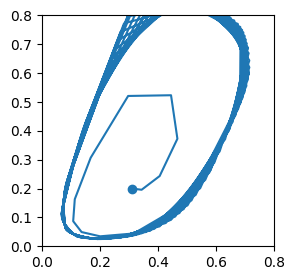

[0.02016308+1.69987321j 0.02016308-1.69987321j]
La partie réelle des racines confirme le caractère instable du point d'équilibre.


In [18]:
d_ext=np.array([4.0,2.0])
x0=np.array([0.310,0.20])
t0=0.0
tf=100.0
dt=5e-1
def g(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext)
plt.scatter(x0[0],x0[1])
plt.plot(solve_euler_explicit(g,x0,dt,t0,tf)[1][:,0],solve_euler_explicit(g,x0,dt,t0,tf)[1][:,1])
plt.xlim(0,0.8)
plt.ylim(0,0.8)
plt.show()
print(np.linalg.eigvals(jacobian_dynamics(0.31,0.2,d_ext))) 
print( "La partie réelle des racines confirme le caractère instable du point d'équilibre.")

9) Le but est ici de trouver un point d'équilibre instable. Si la trace de la jacobienne est négative et son déterminant positif, alors c'est que ses valeurs propres sont toutes les deux négatives, donc que le point d'équilibre est stable. Il faut donc chercher un point d'équilibre (correspondant à l'intersection des deux courbes) en dehors de la zone de trace négative et de déterminant positif en modifiant la valeur de d_ext. Pour d_ext=(4.0,2.0), le point d'équilibre est en dehors de la zone donc est instable. Cela se vérifie alors en traçant graphiquement l'évolution temporelle de x faisant apparaître le cycle limite. 